- 각 store에서 units이 모두 0인 item_nbr은 날린다..
    - 계산량을 줄이기 위해서
    


In [59]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import pylab 
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
sns.set()
%matplotlib inline

In [60]:
key = pd.read_csv('../data/key.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
test = pd.read_csv('../data/test.csv')

In [61]:
weather_ = weather.drop(['date', 'codesum'], axis = 1)

In [5]:
weather_.at[0, 'sunrise']

'-'

In [6]:
col_list = list(weather_.columns)
col_list = col_list[1:]

In [7]:
for num in range(len(weather_)) :
    for col in col_list :
        if 'M' in weather_.at[num, col] or 'T' in weather_.at[num, col] or '-' in weather_.at[num, col] :
            weather_.set_value(num, col, np.nan)

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [8]:
def TM_transform(series, T_replace, M_replace): 
    """
    데이터내의 T, M을 원하는 값으로 바꿔주는 함수
    TM_transform(series, T_replace, M_replace)
    """
    series = series.astype(str).map(lambda s: s.strip())
    series[series == 'T'] = T_replace
    series[series =='M'] = M_replace
    return series.astype('float')

In [9]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [10]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

In [11]:
def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

In [12]:
def preprocessing(df, holiday):
    """
    train데이터를 가공하는 함수
    """
#     df['units'] = np.log(df['units'] + 1)
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend

    # There are values that are computed as being "normal" for a given location. Normal are computed based on 30 years worth of data every ten years. (today temp - normal) = depart
    weather['date'] = pd.to_datetime(weather['date']) #weather는 글로벌변수
    for i in range(len(weather['codesum'])):
        codesum = weather['codesum'][i].split(" ")
        for _ in codesum:
            if _ == 'RA':
                weather.set_value(i, 'rain_flag', 1)
            elif _ == 'SN':
                weather.set_value(i, 'snow_flag', 1)
            elif _ == "":
                weather.set_value(i, 'normal_flag', 1)
            else:
                weather.set_value(i, 'abnormal_flag', 1)

    # return x or y depending on the condition
    # "For the purposes of this competition, we have defined a weather event as any day in which more than an inch of rain or two inches of snow was observed."
    # weather_event =  (((codesum contains SN) and (snowfall > 2)) or ((codesum contains RA) and (preciptotal > 1)))
    weather['preciptotal'] = TM_transform(weather['preciptotal'], 0.005, 0.00)
    weather['snowfall'] = TM_transform(weather['snowfall'], 0.005, 0.00)
    weather['snow_event'] = np.where(np.where(weather['snow_flag'] == 1, 1, 0) + np.where(weather['snowfall'] > 2, 1, 0) == 2, 1, 0)
    weather['rain_event'] = np.where(np.where(weather['rain_flag'] == 1, 1, 0) + np.where(weather['preciptotal'] > 1, 1, 0) == 2, 1, 0)
    weather['event'] = weather['snow_event'] + weather['rain_event']
    

#    weather['preciptotal_flag'] = np.where(weather['preciptotal'] > 0.2, 1, 0)
#     weather['depart'] = TM_transform(weather['depart'], np.nan, 0.00)
#     weather['depart_flag'] = np.where(weather['depart'] > 8.0, 1, 0)
#     weather['depart_flag'] = np.where(weather['depart'] < 8.0, -1, 0)
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    
    df = pd.merge(df, weather[['date', 'station_nbr', 'rain_flag', 'snow_flag', 'normal_flag', 'event']], on=['date', 'station_nbr'])
    return df

In [13]:
holiday12 = find_holiday('../data/holiday.xlsx', '2012')
holiday13 = find_holiday('../data/holiday.xlsx', '2013')
holiday14 = find_holiday('../data/holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)
processed_train = preprocessing(train, holiday)

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [14]:
processed_train.drop(['weekend', 'weekday_holiday', 'weekend_holiday', 'station_nbr',
                      'rain_flag', 'snow_flag', 'normal_flag'], axis = 1, inplace = True)

In [15]:
processed_train.sort_values(by = ['date', 'store_nbr', 'item_nbr'], inplace = True)
processed_train.reset_index(drop = True, inplace = True)

In [16]:
processed_train = processed_train[:2255853]

In [17]:
processed_train.loc[0]

date         2012-01-01 00:00:00
store_nbr                      1
item_nbr                       1
units                          0
weekday                        6
holiday                     True
event                          0
Name: 0, dtype: object

In [18]:
train['log_units'] = np.log(train['units'] + 1)
train.tail()

,date,store_nbr,item_nbr,units,weekday,weekend,holiday,weekday_holiday,weekend_holiday,log_units
4617595,2014-10-31,45,107,0,4,False,True,True,False,0.0
4617596,2014-10-31,45,108,0,4,False,True,True,False,0.0
4617597,2014-10-31,45,109,0,4,False,True,True,False,0.0
4617598,2014-10-31,45,110,0,4,False,True,True,False,0.0
4617599,2014-10-31,45,111,0,4,False,True,True,False,0.0


In [19]:
train_new = train[:2255853]
train_new.head()

,date,store_nbr,item_nbr,units,weekday,weekend,holiday,weekday_holiday,weekend_holiday,log_units
0,2012-01-01,1,1,0,6,True,True,False,True,0.0
1,2012-01-01,1,2,0,6,True,True,False,True,0.0
2,2012-01-01,1,3,0,6,True,True,False,True,0.0
3,2012-01-01,1,4,0,6,True,True,False,True,0.0
4,2012-01-01,1,5,0,6,True,True,False,True,0.0


In [20]:
tmp = train_new.pivot_table(values = 'log_units', index = 'date', columns = ['item_nbr'])
item_nbr_total = list(tmp.columns)

In [21]:
tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]

In [22]:
tmp_ = tmp.reset_index()

In [23]:
tmp_.head()

item_nbr,date,1,2,3,4,5,6,7,8,9,...,93,94,96,97,98,99,100,101,102,103
0,2012-01-01,0.0,0.0,0.0,0.0,1.791893,0.085482,0.024968,0.061547,1.446910,...,0.115345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-02,0.0,0.0,0.0,0.0,1.881895,0.113726,0.015753,0.073156,1.666228,...,0.074905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-03,0.0,0.0,0.0,0.0,1.816595,0.105987,0.031507,0.090659,1.450014,...,0.031507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-04,0.0,0.0,0.0,0.0,1.694559,0.106412,0.000000,0.078767,1.457618,...,0.101758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-05,0.0,0.0,0.0,0.0,1.814586,0.110626,0.015753,0.094520,1.664719,...,0.065690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
tmp_

item_nbr,date,1,2,3,4,5,6,7,8,9,...,93,94,96,97,98,99,100,101,102,103
0,2012-01-01,0.000000,0.000000,0.000000,0.000000,1.791893,0.085482,0.024968,0.061547,1.446910,...,0.115345,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2012-01-02,0.000000,0.000000,0.000000,0.000000,1.881895,0.113726,0.015753,0.073156,1.666228,...,0.074905,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,2012-01-03,0.000000,0.000000,0.000000,0.000000,1.816595,0.105987,0.031507,0.090659,1.450014,...,0.031507,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,2012-01-04,0.000000,0.000000,0.000000,0.000000,1.694559,0.106412,0.000000,0.078767,1.457618,...,0.101758,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,2012-01-05,0.000000,0.000000,0.000000,0.000000,1.814586,0.110626,0.015753,0.094520,1.664719,...,0.065690,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,2012-01-06,0.000000,0.000000,0.000000,0.000000,1.717358,0.099874,0.036578,0.082672,1.488676,...,0.190501,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,2012-01-07,0.000000,0.000000,0.000000,0.000000,1.757953,0.093799,0.036578,0.070251,1.596043,...,0.169425,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,2012-01-08,0.000000,0.000000,0.000000,0.000000,1.857856,0.113419,0.031507,0.089801,1.559476,...,0.135242,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,2012-01-09,0.000000,0.000000,0.000000,0.000000,1.640761,0.106829,0.000000,0.074905,1.523189,...,0.131451,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,2012-01-10,0.000000,0.000000,0.000000,0.000000,1.820724,0.059979,0.036578,0.094872,1.331021,...,0.192927,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [25]:
item_nbr_nonzero = list(tmp.columns)

In [26]:
item_nbr_zero = []

for num in item_nbr_total :
    if num not in item_nbr_nonzero :
        item_nbr_zero.append(num)

In [27]:
item_nbr_zero

[22, 38, 47, 64, 95, 104, 105, 106, 107, 108, 109, 110, 111]

In [28]:
for num in item_nbr_zero :
    train_new_ = train_new[train_new.item_nbr != num[1]]

TypeError: 'int' object is not subscriptable

In [30]:
train_new_.reset_index(drop = True, inplace = True)

NameError: name 'train_new_' is not defined

In [31]:
train_test = preprocessing(train_new_, holiday)

NameError: name 'train_new_' is not defined

In [32]:
train_test
train_test_ = train_test.drop(['weekend', 'weekday_holiday', 'weekend_holiday', 'station_nbr',
                               'rain_flag', 'snow_flag', 'normal_flag', 'units', 'date'], axis = 1)

NameError: name 'train_test' is not defined

In [33]:
train_test_.head()

NameError: name 'train_test_' is not defined

In [34]:
train_test_['store_nbr'] = train_test_['store_nbr'].astype('category')
train_test_['item_nbr'] = train_test_['item_nbr'].astype('category')
train_test_['weekday'] = train_test_['weekday'].astype('category')
train_test_['holiday'] = train_test_['holiday'].astype('category')
train_test_['event'] = train_test_['event'].astype('category')

NameError: name 'train_test_' is not defined

In [35]:
model1 = sm.OLS.from_formula("log_units ~ store_nbr + item_nbr + weekday + holiday + event", data = train_test_)

NameError: name 'train_test_' is not defined

In [36]:
result1 = model1.fit()
print(result1.summary())

NameError: name 'model1' is not defined

In [37]:
model2 = sm.OLS.from_formula("log_units ~ store_nbr + item_nbr + weekday + holiday + event + 0", data = train_test_)

NameError: name 'train_test_' is not defined

In [38]:
result2 = model2.fit()
print(result2.summary())

NameError: name 'model2' is not defined

In [39]:
model3 = sm.OLS.from_formula("log_units ~ C(store_nbr) + C(item_nbr) + C(weekday) + C(holiday) + C(event)", data = train_test_)

NameError: name 'train_test_' is not defined

In [40]:
result3 = model3.fit()
print(result3.summary())

NameError: name 'model3' is not defined

In [41]:
model4 = sm.OLS.from_formula("log_units ~ C(store_nbr) + C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0 + 0 + 0 + 0 + 0", data = train_test_)

NameError: name 'train_test_' is not defined

In [42]:
result4 = model4.fit()
print(result4.summary())

NameError: name 'model4' is not defined

In [43]:
model5 = sm.OLS.from_formula("log_units ~ C(item_nbr) + 0", data = train_test_)
result5 = model5.fit()
print(result5.summary())

NameError: name 'train_test_' is not defined

In [44]:
tmp2 = train_new.pivot_table(values = 'log_units', index = ['date', 'store_nbr', 'item_nbr'])
tmp2_ = tmp2[tmp2['log_units'] != 0]

In [45]:
tmp2_ = tmp2_.reset_index()

In [46]:
tmp2_ = preprocessing(tmp2_, holiday)

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [47]:
tmp2_test = tmp2_.drop(['weekend', 'weekday_holiday', 'weekend_holiday', 'station_nbr',
                               'rain_flag', 'snow_flag', 'normal_flag', 'date'], axis = 1)

In [58]:
len(test2_test)

NameError: name 'test2_test' is not defined

In [48]:
tmp2_test['store_nbr'] = tmp2_test['store_nbr'].astype('category')
tmp2_test['item_nbr'] = tmp2_test['item_nbr'].astype('category')
tmp2_test['weekday'] = tmp2_test['weekday'].astype('category')
tmp2_test['holiday'] = tmp2_test['holiday'].astype('category')
tmp2_test['event'] = tmp2_test['event'].astype('category')

In [49]:
model = sm.OLS.from_formula("log_units ~ C(store_nbr) + C(item_nbr) + C(weekday) + holiday + event + 0", data = tmp2_test)

In [50]:
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     2829.
Date:                Sat, 03 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:40:36   Log-Likelihood:                -45406.
No. Observations:               61318   AIC:                         9.111e+04
Df Residuals:                   61168   BIC:                         9.247e+04
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(store_nbr)[1]        1.2953      0

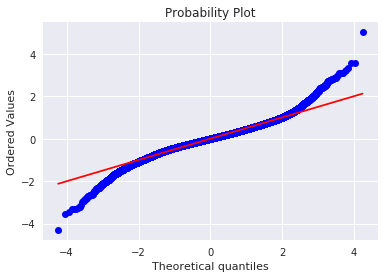

In [54]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [56]:
test = sm.stats.stattools.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 4268.417
P-value     :  0.000


In [57]:
test = sm.stats.stattools.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera : 22321.486
P-value     :  0.000
Skew        : -0.032
Kurtosis    :  5.955


In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.show()

KeyboardInterrupt: 

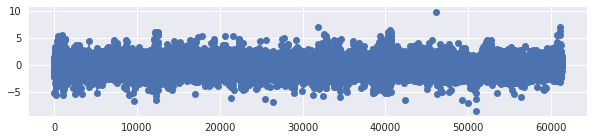

In [51]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.show()